## Role Labeling
Section 4.2.3 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/soccercpd'

In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

In [3]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.rolerep import RoleRep
from src.form_manager import FormManager

In [4]:
form_periods = pd.read_pickle('data/form_periods.pkl')
role_records = pd.read_csv('data/role_records.csv', header=0, encoding='utf-8-sig')
activity_records = pd.read_csv('data/activity_records.csv', header=0, encoding='utf-8-sig')

form_periods = pd.merge(
    activity_records[[LABEL_ACTIVITY_ID, LABEL_TEAM_ID, LABEL_DATE, LABEL_TEAM_NAME]], form_periods
)
# role_records[LABEL_START_DT] = role_records[LABEL_START_DT].apply(
#     lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# role_records[LABEL_END_DT] = role_records[LABEL_END_DT].apply(
#     lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

form_periods.head()

,activity_id,team_id,date,team_name,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,1879,8,20200101,anonymous,1,1,2020-01-01 16:00:00,2020-01-01 16:47:00,2820.0,"[[1710.0, -60.0], [133.0, -750.0], [1042.0, 18...","[[0.0, 0.715, 0.916, 0.974, 0.252, 0.023, 0.11...",16,433
1,1879,8,20200101,anonymous,2,2,2020-01-01 17:02:00,2020-01-01 17:53:00,3060.0,"[[1701.0, 24.0], [643.0, -620.0], [674.0, 1848...","[[0.0, 0.864, 0.888, 0.847, 0.266, 0.062, 0.1,...",16,433
2,1882,127,20200101,anonymous,1,1,2020-01-01 15:00:00,2020-01-01 15:46:00,2760.0,"[[-620.0, 1799.0], [-1366.0, -682.0], [-1525.0...","[[0.0, 0.124, 0.976, 0.907, 0.235, 0.99, 0.041...",-1,others
3,1882,127,20200101,anonymous,2,2,2020-01-01 16:02:00,2020-01-01 16:44:00,2520.0,"[[-896.0, 1434.0], [-1231.0, -705.0], [-1400.0...","[[0.0, 0.253, 0.995, 0.764, 0.177, 0.942, 0.12...",5,4132
4,1882,127,20200101,anonymous,2,3,2020-01-01 16:44:00,2020-01-01 16:51:00,420.0,"[[-810.0, 1465.0], [-1275.0, -668.0], [-1832.0...","[[0.0, 0.171, 0.986, 0.691, 0.231, 0.865, 0.12...",5,4132


Roles aligned for formation '343'
Roles aligned for formation '352'
Roles aligned for formation '4132'
Roles aligned for formation '4231'
Roles aligned for formation '433'
Roles aligned for formation '442'
Roles aligned for formation 'others'


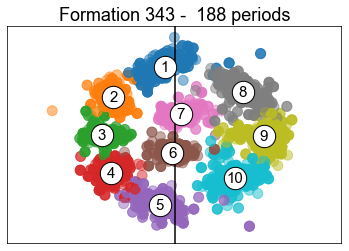

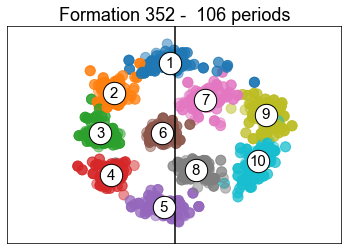

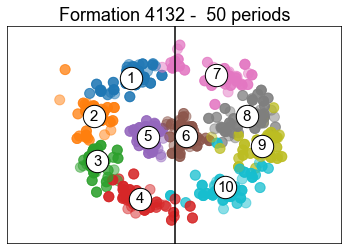

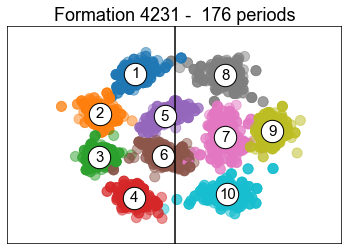

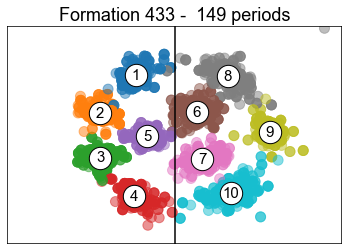

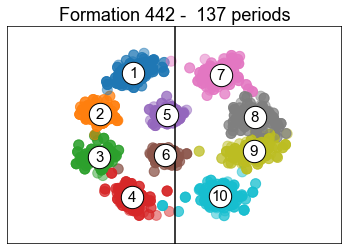

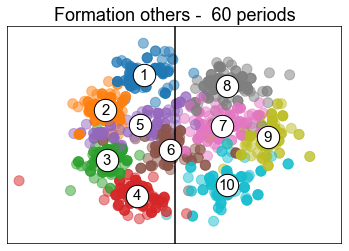

In [5]:
fm = FormManager(form_periods, role_records)
fm.align()
fm.visualize()

### Assigning soccer-specific role labels for ordinary formations

In [7]:
role_labels = pd.DataFrame([
    ['343', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'RCM', 'LCM', 'LM', 'CF', 'RM'],
    ['352', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'CDM', 'LCM', 'RCM', 'LCF', 'RCF'],
    ['442', 'LB', 'LCB', 'RCB', 'RB', 'LCM', 'RCM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4132', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'CAM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4231', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'CAM', 'LM', 'CF', 'RM'],
    ['433', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'LCM', 'RCM', 'LM', 'CF', 'RM'],
    ['others'] + [f'R{i}' for i in list(range(1, 11))]
], columns=[LABEL_FORMATION] + list(range(1, 11))).set_index(LABEL_FORMATION)
role_labels

,1,2,3,4,5,6,7,8,9,10
formation,,,,,,,,,,
343,LWB,LCB,CB,RCB,RWB,RCM,LCM,LM,CF,RM
352,LWB,LCB,CB,RCB,RWB,CDM,LCM,RCM,LCF,RCF
442,LB,LCB,RCB,RB,LCM,RCM,LM,LCF,RCF,RM
4132,LB,LCB,RCB,RB,CDM,CAM,LM,LCF,RCF,RM
4231,LB,LCB,RCB,RB,LDM,RDM,CAM,LM,CF,RM
433,LB,LCB,RCB,RB,CDM,LCM,RCM,LM,CF,RM
others,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10


In [8]:
def give_role_labels(role_records, role_labels):
    formation = role_records[LABEL_FORMATION].iloc[0]
    role_dict = role_labels.loc[formation].to_dict()
    role_records.loc[role_records.index, LABEL_ALIGNED_ROLE] = (
        role_records.loc[role_records.index, LABEL_ALIGNED_ROLE].replace(role_dict)
    )
    return role_records

In [9]:
role_records = fm.role_records.groupby(LABEL_FORMATION).apply(give_role_labels, role_labels)
role_records

,activity_id,player_period,form_period,role_period,session,start_dt,end_dt,duration,player_id,squad_num,player_name,base_role,x,y,formation,aligned_role
0,1879,1,1,1,1,2020-01-01 16:00:00,2020-01-01 16:35:00,2100,1252,9,P09,1,1696.0,-65.0,433,CF
1,1879,1,1,1,1,2020-01-01 16:00:00,2020-01-01 16:35:00,2100,1759,10,P10,2,136.0,-745.0,433,RCM
2,1879,1,1,1,1,2020-01-01 16:00:00,2020-01-01 16:35:00,2039,1760,14,P14,3,1037.0,1791.0,433,LM
3,1879,1,1,1,1,2020-01-01 16:00:00,2020-01-01 16:35:00,2100,1761,15,P15,4,815.0,-1458.0,433,RM
4,1879,1,1,1,1,2020-01-01 16:00:00,2020-01-01 16:35:00,2100,1237,19,P19,5,-621.0,-94.0,433,CDM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21123,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5781,19,P19,5,367.0,-385.0,others,R6
21124,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5204,20,P20,7,-1087.0,-359.0,others,R3
21125,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5450,23,P23,3,1264.0,-275.0,others,R9
21126,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,4643,33,P33,9,-1185.0,420.0,others,R2


### Visualizing roles with soccer-specific labels

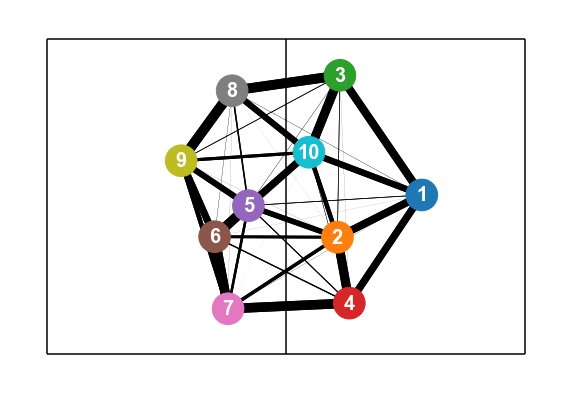

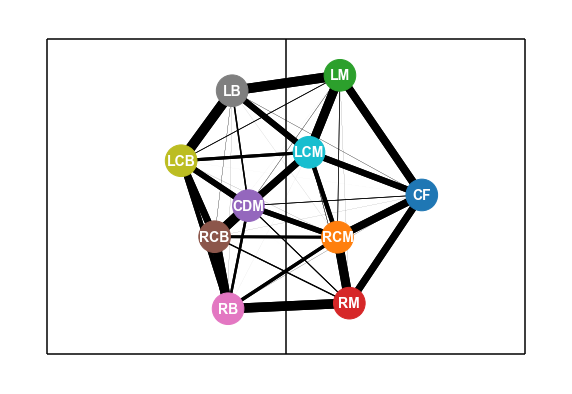

In [24]:
# Choose an activity and a formation period
activity_id = 1879
form_period = 2

form_idx = form_periods[
    (form_periods[LABEL_ACTIVITY_ID] == activity_id) &
    (form_periods[LABEL_FORM_PERIOD] == form_period)
].index[0]
mean_coords = form_periods.at[form_idx, LABEL_COORDS]
mean_edge_mat = form_periods.at[form_idx, LABEL_EDGE_MAT]

unit_role_records = role_records[
    (role_records[LABEL_ACTIVITY_ID] == activity_id) &
    (role_records[LABEL_FORM_PERIOD] == form_period)
]
labels = dict(zip(unit_role_records[LABEL_BASE_ROLE], unit_role_records[LABEL_ALIGNED_ROLE]))

# Without aligned role labels
FormManager.visualize_single_graph(mean_coords, mean_edge_mat)

# With aligned role labels
FormManager.visualize_single_graph(mean_coords, mean_edge_mat, labels)

(-3000.0, 3000.0, -3000.0, 3000.0)

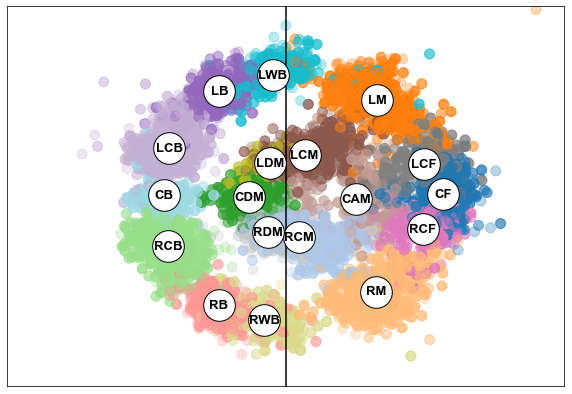

In [25]:
ordinary_role_records = role_records[role_records[LABEL_FORMATION] != 'others']
x = ordinary_role_records[LABEL_X]
y = ordinary_role_records[LABEL_Y]
ordinary_roles = ordinary_role_records[LABEL_ALIGNED_ROLE].unique()
role_to_color = dict(zip(ordinary_roles, np.arange(len(ordinary_roles))))
colors = ordinary_role_records[LABEL_ALIGNED_ROLE].apply(lambda x: role_to_color[x])

plt.figure(figsize=(10, 7))
plt.scatter(x, y, s=100, c=colors, alpha=0.3, cmap='tab20', zorder=0)

mean_coords = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE)[[LABEL_X, LABEL_Y]].mean()
plt.scatter(mean_coords[LABEL_X], mean_coords[LABEL_Y], s=1000, c='w', edgecolors='k', zorder=1)
for r in mean_coords.index:
    plt.annotate(r, xy=mean_coords.loc[r], ha='center', va='center', fontsize=13, fontweight='bold', zorder=2)

xlim = 3000
ylim = 3000
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
plt.axis('off')

### Assigning domain-specific role labels for 'others' formations

In [26]:
role_distns = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE).apply(
    RoleRep._estimate_mvn, col_x=LABEL_X, col_y=LABEL_Y, filter=False
)
role_distns

aligned_role
CAM    <scipy.stats._multivariate.multivariate_normal...
CB     <scipy.stats._multivariate.multivariate_normal...
CDM    <scipy.stats._multivariate.multivariate_normal...
CF     <scipy.stats._multivariate.multivariate_normal...
LB     <scipy.stats._multivariate.multivariate_normal...
LCB    <scipy.stats._multivariate.multivariate_normal...
LCF    <scipy.stats._multivariate.multivariate_normal...
LCM    <scipy.stats._multivariate.multivariate_normal...
LDM    <scipy.stats._multivariate.multivariate_normal...
LM     <scipy.stats._multivariate.multivariate_normal...
LWB    <scipy.stats._multivariate.multivariate_normal...
RB     <scipy.stats._multivariate.multivariate_normal...
RCB    <scipy.stats._multivariate.multivariate_normal...
RCF    <scipy.stats._multivariate.multivariate_normal...
RCM    <scipy.stats._multivariate.multivariate_normal...
RDM    <scipy.stats._multivariate.multivariate_normal...
RM     <scipy.stats._multivariate.multivariate_normal...
RWB    <scipy.stat

In [27]:
def hungarian(unit_role_records):
    cost_mat = unit_role_records[ordinary_roles].values
    _, col_idx = linear_sum_assignment(cost_mat)
    role_records.loc[unit_role_records.index, LABEL_ALIGNED_ROLE] = ordinary_roles[col_idx]
    # return unit_role_records[HEADER_ROLE_RECORDS + [LABEL_ALIGNED_ROLE]]

In [28]:
other_form_periods = form_periods[form_periods[LABEL_FORMATION] == 'others']
other_role_records = pd.merge(role_records, other_form_periods[[LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD]])

cost_df = role_distns.apply(
    lambda n: pd.Series(-np.log(n.pdf(other_role_records[[LABEL_X, LABEL_Y]])))
).transpose()
other_role_records = pd.concat([other_role_records, cost_df], axis=1)
other_role_records.index = role_records[role_records[LABEL_FORMATION] == 'others'].index
other_role_records.groupby([LABEL_ACTIVITY_ID, LABEL_ROLE_PERIOD]).apply(hungarian)

role_records[role_records[LABEL_FORMATION] == 'others']

,activity_id,player_period,form_period,role_period,session,start_dt,end_dt,duration,player_id,squad_num,player_name,base_role,x,y,formation,aligned_role
59,1882,1,1,1,1,2020-01-01 15:00:00,2020-01-01 15:24:10,1450,1849,2,P02,1,-603.0,1789.0,others,LB
60,1882,1,1,1,1,2020-01-01 15:00:00,2020-01-01 15:24:10,1450,1850,3,P03,2,-1342.0,-659.0,others,RCB
61,1882,1,1,1,1,2020-01-01 15:00:00,2020-01-01 15:24:10,1450,1851,4,P04,3,-1536.0,642.0,others,LCB
62,1882,1,1,1,1,2020-01-01 15:00:00,2020-01-01 15:24:10,1450,1855,8,P08,4,-494.0,546.0,others,LDM
63,1882,1,1,1,1,2020-01-01 15:00:00,2020-01-01 15:24:10,1450,1857,10,P10,5,1218.0,231.0,others,LCF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21123,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5781,19,P19,5,367.0,-385.0,others,RCM
21124,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5204,20,P20,7,-1087.0,-359.0,others,RCB
21125,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,5450,23,P23,3,1264.0,-275.0,others,RCF
21126,22875,4,3,6,2,2020-01-01 16:51:20,2020-01-01 16:58:00,400,4643,33,P33,9,-1185.0,420.0,others,CB


Activity ID: 1882, Formation period: 1


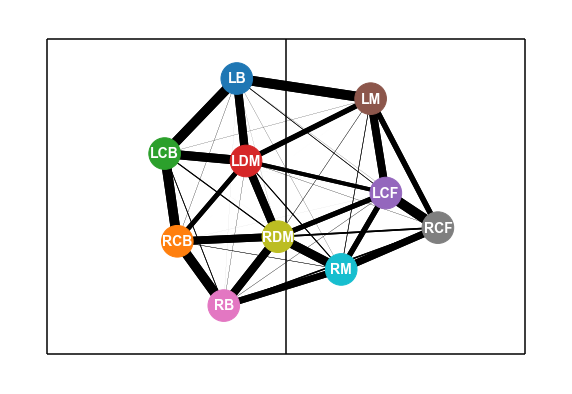

In [29]:
# Visualize a formation period whose formation is classified as 'others'

i = 0  # Choose from 0 to 59
form_row = other_form_periods.iloc[i]

form_idx = form_row.name
activity_id = form_row[LABEL_ACTIVITY_ID]
form_period = form_row[LABEL_FORM_PERIOD]
print(f'Activity ID: {activity_id}, Formation period: {form_period}')

mean_coords = form_periods.at[form_idx, LABEL_COORDS]
mean_edge_mat = form_periods.at[form_idx, LABEL_EDGE_MAT]

unit_role_records = role_records[
    (role_records[LABEL_ACTIVITY_ID] == activity_id) &
    (role_records[LABEL_FORM_PERIOD] == form_period)
]
labels = dict(zip(unit_role_records[LABEL_BASE_ROLE], unit_role_records[LABEL_ALIGNED_ROLE]))

FormManager.visualize_single_graph(mean_coords, mean_edge_mat, labels)

In [30]:
role_records.to_csv('data/role_records.csv', index=False)